In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

class DBSCAN:
    def __init__(self, eps=0.1, minPts=3):
        self.eps = eps
        self.minPts = minPts
        self.clusterCount = 0

    def Distance(self, x, y):
        d = np.linalg.norm(x - y)
        return d

    def RangeQuery(self, data, i):
        point_count = len(data)
        neighbours = np.array([], dtype=int)
        for j in np.arange(point_count):
            d = self.Distance(data[i], data[j])
            if d <= self.eps:
                neighbours = np.append(neighbours, [j])
        return neighbours

    def cluster(self, data):
        point_count = len(data)
        label = np.zeros((point_count), dtype=int)

        for i in np.arange(point_count):
            if label[i] != 0:
                continue
            neighbours = self.RangeQuery(data, i)
            if len(neighbours) < self.minPts:
                label[i] = -1
                continue

            self.clusterCount = self.clusterCount + 1
            label[i] = self.clusterCount

            seed_set = np.setdiff1d(neighbours, [i])
            for k in seed_set:
                if label[k] == -1:
                    label[k] = self.clusterCount
                if label[k] != 0:
                    continue
                label[k] = self.clusterCount
                other_neighbours = self.RangeQuery(data, k)
                if len(other_neighbours) >= self.minPts:
                    seed_set = np.append(seed_set, other_neighbours)

        return label

    def calculate_silhouette_scores(self, data, result_labels):
        silhouette_scores = []
        avg_silhouette_scores = []

        for cluster_label in range(1, self.clusterCount + 1):
            cluster_mask = (result_labels == cluster_label)
            if np.sum(cluster_mask) > 1:  # Silhouette score is only meaningful for clusters with more than one point
                cluster_silhouette = self.calculate_cluster_silhouette(data, result_labels, cluster_mask)
                avg_silhouette = np.mean(cluster_silhouette)

                # Append results to lists
                silhouette_scores.append(cluster_silhouette)  # Use extend instead of append
                avg_silhouette_scores.append(avg_silhouette)
                print(f"Silhouette score for Cluster {cluster_label}: {avg_silhouette}")

        return silhouette_scores, avg_silhouette_scores

    def calculate_cluster_silhouette(self, data, result_labels, cluster_mask):
        cluster_silhouette = []
        for i in range(len(result_labels)):
            if cluster_mask[i]:
                a_i = np.mean([self.Distance(data[i], data[j]) for j in range(len(result_labels)) if cluster_mask[j] and i != j])

                b_i_values = []
                for other_cluster_label in range(1, self.clusterCount + 1):
                    if other_cluster_label != result_labels[i]:
                        other_cluster_mask = (result_labels == other_cluster_label)
                        b_i_values.append(np.mean([self.Distance(data[i], data[j]) for j in range(len(result_labels)) if other_cluster_mask[j]]))

                b_i = min(b_i_values) if b_i_values else 0
                silhouette_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) != 0 else 0
                cluster_silhouette.append(silhouette_i)

        return cluster_silhouette
    

def find_optimal_params(data, eps_range, minPts_range):
    best_eps = None
    best_minPts = None
    best_avg_silhouette = -1

    for eps in eps_range:
        for minPts in minPts_range:
            dbscan = DBSCAN(eps=eps, minPts=minPts)
            result_labels = dbscan.cluster(data)
            _, avg_silhouette_scores = dbscan.calculate_silhouette_scores(data, result_labels)
            overall_avg_silhouette = np.mean(avg_silhouette_scores)

            print(f"Parameters: eps={eps}, minPts={minPts}, Overall Avg Silhouette Score: {overall_avg_silhouette}")

            if overall_avg_silhouette > best_avg_silhouette:
                best_eps = eps
                best_minPts = minPts
                best_avg_silhouette = overall_avg_silhouette

    return best_eps, best_minPts

def read_csv(file_path):
    data = []
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        header = next(csv_reader)  # Skip the header row
        for row in csv_reader:
            data.append(list(map(float, row)))
    return np.array(data)


# Read data from CSV file
file_path = '../dataset/afterDS.csv'
original_data = read_csv(file_path)
data_normalize = (original_data - np.mean(original_data, axis=0)) / np.std(original_data, axis=0)

# Define ranges for eps and minPts
eps_range = np.arange(3, 5.0, 0.1)
minPts_range = np.arange(30, 60, 5)

# Find optimal parameters
best_eps, best_minPts = find_optimal_params(data_normalize, eps_range, minPts_range)

# Instantiate DBSCAN with optimal parameters
dbscan = DBSCAN(eps=best_eps, minPts=best_minPts)
result_labels = dbscan.cluster(data_normalize)

# Print data points with their cluster labels
for i, label in enumerate(result_labels):
    print(f"Data point {i}: Cluster {label}")

# Initialize lists to store feature results
features_data = []

# Append feature data to features_data
for i, label in enumerate(result_labels):
    features_data.append(list(original_data[i]) + [label-1])

# Find optimal parameters
best_eps, best_minPts = find_optimal_params(data_normalize, eps_range, minPts_range)

# Instantiate DBSCAN with optimal parameters
dbscan = DBSCAN(eps=best_eps, minPts=best_minPts)
result_labels = dbscan.cluster(data_normalize)
silhouette_scores, avg_silhouette_scores = dbscan.calculate_silhouette_scores(data_normalize, result_labels)
# Save results to CSV file
output_file_path = '../Results/DBSCAN/DBSCAN_After/dbscan_after_Result.csv'
with open(output_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Cluster_ID', 'Silhouette_Score', 'Avg_Silhouette_Score'])
    overall_avg_silhouette = np.mean(avg_silhouette_scores)
    for i in range(len(silhouette_scores)):
        if 0 <= i < len(avg_silhouette_scores):
            writer.writerow([i, avg_silhouette_scores[i], overall_avg_silhouette])
# Save features results to CSV file
features_output_file_path = '../Results/DBSCAN/DBSCAN_After/dbscan_after_Cluster.csv'
with open(features_output_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'Intra', 'Inter', 'Proximity', 'RoG', 'Cluster'])
    writer.writerows(features_data)
print(f"Overall Average Silhouette Score: {overall_avg_silhouette}")

print(f"Optimal Parameters: eps={best_eps}, minPts={best_minPts}")


Silhouette score for Cluster 1: 0.1218701776927589
Silhouette score for Cluster 2: 0.1554748987870657
Silhouette score for Cluster 3: 0.022631015408069638
Silhouette score for Cluster 4: 0.2035425644572943
Silhouette score for Cluster 5: 0.12602163185115087
Parameters: eps=3.0, minPts=30, Overall Avg Silhouette Score: 0.12590805763926788
Silhouette score for Cluster 1: 0.1514401849410734
Silhouette score for Cluster 2: 0.05414738004865176
Silhouette score for Cluster 3: 0.21952892243224306
Silhouette score for Cluster 4: 0.18992014406492522
Parameters: eps=3.0, minPts=35, Overall Avg Silhouette Score: 0.15375915787172334
Silhouette score for Cluster 1: 0.09910268134250834
Silhouette score for Cluster 2: 0.1639175693100491
Silhouette score for Cluster 3: 0.11233513936960464
Silhouette score for Cluster 4: 0.1003686137870214
Silhouette score for Cluster 5: 0.07184560261173453
Parameters: eps=3.0, minPts=40, Overall Avg Silhouette Score: 0.10951392128418361
Silhouette score for Cluster 1:

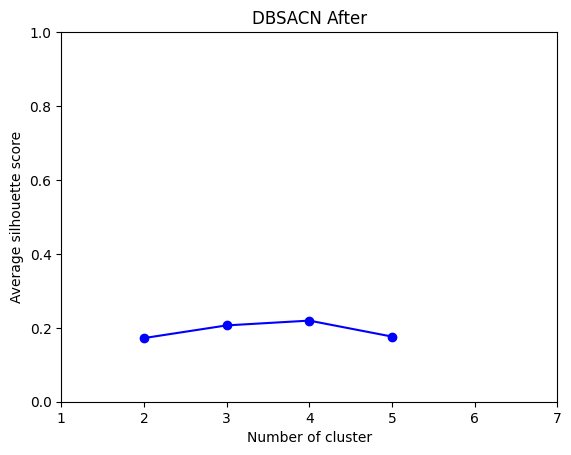

In [37]:
import csv
import matplotlib.pyplot as plt

def plot_line_graph(file_path, x_axis_limit=None, y_axis_limit=None):
    x_values = []
    y_values = []

    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader, None)  # Skip the header row
        for row in reader:
            if row[0].strip() and row[1].strip():  # Check if both values are non-empty
                x_values.append(float(row[0]))
                y_values.append(float(row[1]))


    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')  # Adjust color and style as needed
    plt.title('DBSACN After')
    plt.xlabel('Number of cluster')
    plt.ylabel('Average silhouette score')

    if x_axis_limit is not None:
        plt.xlim(x_axis_limit)
    
    if y_axis_limit is not None:
        plt.ylim(y_axis_limit)

    plt.show()

# Example usage with custom axis limits:
csv_file_path = '../Results/DBSCAN/DBSCAN_After/DBSCAN_afterDS_TotalResult.csv'
x_limit = (1, 7)  # Specify the desired x-axis limits
y_limit = (0, 1)  # Specify the desired y-axis limits
plot_line_graph(csv_file_path, x_axis_limit=x_limit, y_axis_limit=y_limit)